# Jane Street: Supervised Autoencoder MLP
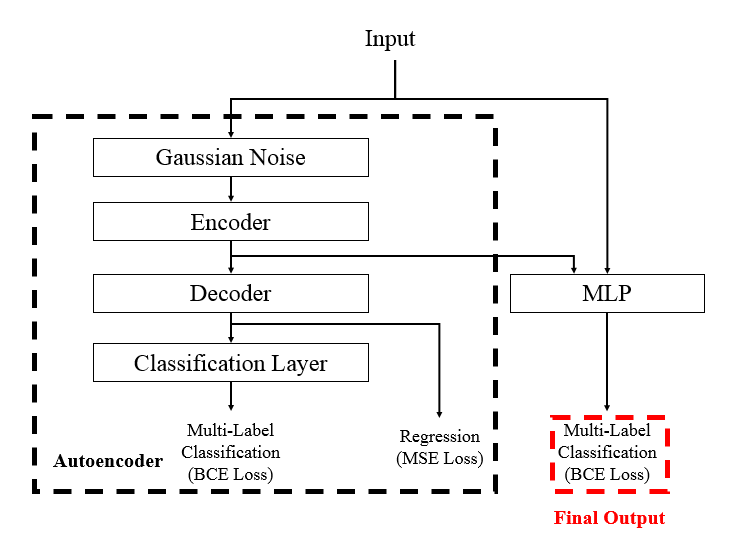

Reference:
[Bottleneck encoder + MLP + Keras Tuner 8601c5][1]

[1]: https://www.kaggle.com/aimind/bottleneck-encoder-mlp-keras-tuner-8601c5

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, gc
import pandas as pd
import numpy as np
import janestreet
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import dump, load
import datatable as dtable

import tensorflow as tf
tf.random.set_seed(42)
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

TEST = False

In [ ]:
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

In [ ]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

# Preprocessing

In [ ]:
if TEST:
    train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv', nrows = 100)
    features = [c for c in train.columns if 'feature' in c]
else:
    print('Loading...')
    train = dtable.fread('../input/jane-street-market-prediction/train.csv').to_pandas()
    features = [c for c in train.columns if 'feature' in c]

    print('Filling...')
    train = train.query('date > 85').reset_index(drop = True) 
    train = train.query('weight > 0').reset_index(drop = True)
    train[features] = train[features].fillna(method = 'ffill').fillna(0)
    train['action'] = ((train['resp_1'] > 0) & (train['resp_2'] > 0) & (train['resp_3'] > 0) & (train['resp_4'] > 0) & (train['resp'] > 0)).astype('int')

    resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3', 'resp_4']

    X = train[features].values
    y = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T
    date = train['date'].values
    weight = train['weight'].values
    resp = train['resp'].values
    sw = np.mean(np.abs(train[resp_cols].values), axis = 1)

In [ ]:
n_splits = 5
group_gap = 31

# Training

In [ ]:
def create_ae_mlp(num_columns, num_labels, hidden_units, dropout_rates, ls = 1e-2, lr = 1e-3):
    
    inp = tf.keras.layers.Input(shape = (num_columns, ))
    x0 = tf.keras.layers.BatchNormalization()(inp)
    
    encoder = tf.keras.layers.GaussianNoise(dropout_rates[0])(x0)
    encoder = tf.keras.layers.Dense(hidden_units[0])(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('swish')(encoder)
    
    decoder = tf.keras.layers.Dropout(dropout_rates[1])(encoder)
    decoder = tf.keras.layers.Dense(num_columns, name = 'decoder')(decoder)

    x_ae = tf.keras.layers.Dense(hidden_units[1])(decoder)
    x_ae = tf.keras.layers.BatchNormalization()(x_ae)
    x_ae = tf.keras.layers.Activation('swish')(x_ae)
    x_ae = tf.keras.layers.Dropout(dropout_rates[2])(x_ae)

    out_ae = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'ae_action')(x_ae)
    
    x = tf.keras.layers.Concatenate()([x0, encoder])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_rates[3])(x)
    
    for i in range(2, len(hidden_units)):
        x = tf.keras.layers.Dense(hidden_units[i])(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rates[i + 2])(x)
        
    out = tf.keras.layers.Dense(num_labels, activation = 'sigmoid', name = 'action')(x)
    
    model = tf.keras.models.Model(inputs = inp, outputs = [decoder, out_ae, out])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
                  loss = {'decoder': tf.keras.losses.MeanSquaredError(), 
                          'ae_action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls),
                          'action': tf.keras.losses.BinaryCrossentropy(label_smoothing = ls), 
                         },
                  metrics = {'decoder': tf.keras.metrics.MeanAbsoluteError(name = 'MAE'), 
                             'ae_action': tf.keras.metrics.AUC(name = 'AUC'), 
                             'action': tf.keras.metrics.AUC(name = 'AUC'), 
                            }, 
                 )
    
    return model

In [ ]:
params = {'num_columns': len(features), 
          'num_labels': 5, 
          'hidden_units': [96, 96, 896, 448, 448, 256], 
          'dropout_rates': [0.03527936123679956, 0.038424974585075086, 0.42409238408801436, 0.10431484318345882, 0.49230389137187497, 0.32024444956111164, 0.2716856145683449, 0.4379233941604448], 
          'ls': 0, 
          'lr':1e-3, 
         }

In [ ]:
if not TEST:
    scores = []
    batch_size = 4096
    gkf = PurgedGroupTimeSeriesSplit(n_splits = n_splits, group_gap = group_gap)
    for fold, (tr, te) in enumerate(gkf.split(train['action'].values, train['action'].values, train['date'].values)):
        ckp_path = f'JSModel_{fold}.hdf5'
        model = create_ae_mlp(**params)
        ckp = ModelCheckpoint(ckp_path, monitor = 'val_action_AUC', verbose = 0, 
                              save_best_only = True, save_weights_only = True, mode = 'max')
        es = EarlyStopping(monitor = 'val_action_AUC', min_delta = 1e-4, patience = 10, mode = 'max', 
                           baseline = None, restore_best_weights = True, verbose = 0)
        history = model.fit(X[tr], [X[tr], y[tr], y[tr]], validation_data = (X[te], [X[te], y[te], y[te]]), 
                            sample_weight = sw[tr], 
                            epochs = 100, batch_size = batch_size, callbacks = [ckp, es], verbose = 0)
        hist = pd.DataFrame(history.history)
        score = hist['val_action_AUC'].max()
        print(f'Fold {fold} ROC AUC:\t', score)
        scores.append(score)

        K.clear_session()
        del model
        rubbish = gc.collect()
    
    print('Weighted Average CV Score:', weighted_average(scores))